<h1 align="center"> Using Unsupervised Methods to Cluster Speed Dating Participants </h1>

### *Notebook created by SEJAS, Martin*

This notebook will attempt to explore and find patterns on the "speed_dating.csv" dataset. A comprehensive dataset of 120 features collected during a speed dating event. 

In my exploration I will try to reduce the dimensionality of the dataset while still keeping the most relevant features. 

My overarching goal in this exploration, is to attempt to cluster the different groups present in the event, and to understand their behaviour. 

We can start by loading the required imports

In [1]:
import pandas as pd 
import numpy as np
import sklearn 
import matplotlib.pyplot as plt

## Step 0: Exploring the Dataset

We can load the csv and see what it looks like

In [2]:
#I'm making a 'master' copy so I always have intact my original dataset
master = pd.read_csv("speed_dating.csv")

df = master.copy()

df.head()

,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,0,1.0,female,21.0,27.0,6.0,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,0
1,0,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[5-6],1.0,0
2,1,1.0,female,21.0,22.0,1.0,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,...,4.0,[0-4],[0-3],[3-5],7.0,5.0,[6-8],[0-4],1.0,1
3,0,1.0,female,21.0,23.0,2.0,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,[0-4],[0-3],[3-5],7.0,6.0,[6-8],[5-6],0.0,1
4,0,1.0,female,21.0,24.0,3.0,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,...,4.0,[0-4],[0-3],[3-5],6.0,6.0,[6-8],[5-6],0.0,1


In [3]:
df.shape

(8378, 120)

As you can see here it seems our dataset has 120 features, which would make it  hard to visualize. To visualize anything as humans, we will need to attempt to plot the data into a 2 dimensional or 3 dimensional space. My hypothesis is that a lot of these features are correlated, and will start by doing some PCA analysis, and try to extract the features that compose up to 95% of the total variance.

120 features are a bit too much to analyze by hand so using machine learning techniques are the best way forward. 

Additionally, in this context, I have a lot of categorical (Discrete) variables, which means I have reduced noise, which can favor some techniques over others, but we will touch more on that later.

Before doing my analysis I want to check the integrity of the data, see if I have any missing values, and possibly remove them from my dataset if possible, as nan's will greatly affect my visualization. 



In [4]:
df.isnull().values.any()

False

Luckily I have no nan values, however before I do any unsupervised technique, I need to pre-process my dataset. First I will see what features I have that are categorical.

In [5]:
categorical_features = df.select_dtypes(include=["object"])

print(len(categorical_features.columns))

categorical_features

59


,gender,d_d_age,race,race_o,d_importance_same_race,d_importance_same_religion,field,d_pref_o_attractive,d_pref_o_sincere,d_pref_o_intelligence,...,d_concerts,d_music,d_shopping,d_yoga,d_interests_correlate,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,d_like,d_guess_prob_liked
0,female,[4-6],Asian/Pacific Islander/Asian-American,European/Caucasian-American,[2-5],[2-5],Law,[21-100],[16-20],[16-20],...,[9-10],[9-10],[6-8],[0-5],[0-0.33],[0-4],[0-3],[3-5],[6-8],[5-6]
1,female,[0-1],Asian/Pacific Islander/Asian-American,European/Caucasian-American,[2-5],[2-5],Law,[21-100],[0-15],[0-15],...,[9-10],[9-10],[6-8],[0-5],[0.33-1],[0-4],[0-3],[3-5],[6-8],[5-6]
2,female,[0-1],Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,[2-5],[2-5],Law,[16-20],[16-20],[16-20],...,[9-10],[9-10],[6-8],[0-5],[0-0.33],[0-4],[0-3],[3-5],[6-8],[0-4]
3,female,[2-3],Asian/Pacific Islander/Asian-American,European/Caucasian-American,[2-5],[2-5],Law,[21-100],[0-15],[0-15],...,[9-10],[9-10],[6-8],[0-5],[0.33-1],[0-4],[0-3],[3-5],[6-8],[5-6]
4,female,[2-3],Asian/Pacific Islander/Asian-American,Latino/Hispanic American,[2-5],[2-5],Law,[21-100],[0-15],[16-20],...,[9-10],[9-10],[6-8],[0-5],[0-0.33],[0-4],[0-3],[3-5],[6-8],[5-6]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8373,male,[0-1],European/Caucasian-American,Latino/Hispanic American,[0-1],[0-1],Climate Dynamics,[0-15],[0-15],[21-100],...,[9-10],[9-10],[6-8],[0-5],[0.33-1],[7-10],[0-3],[3-5],[0-5],[5-6]
8374,male,[0-1],European/Caucasian-American,Other,[0-1],[0-1],Climate Dynamics,[21-100],[16-20],[0-15],...,[9-10],[9-10],[6-8],[0-5],[0.33-1],[7-10],[0-3],[3-5],[0-5],[0-4]
8375,male,[4-6],European/Caucasian-American,Latino/Hispanic American,[0-1],[0-1],Climate Dynamics,[21-100],[0-15],[21-100],...,[9-10],[9-10],[6-8],[0-5],[-1-0],[7-10],[0-3],[3-5],[6-8],[5-6]
8376,male,[2-3],European/Caucasian-American,Asian/Pacific Islander/Asian-American,[0-1],[0-1],Climate Dynamics,[0-15],[21-100],[21-100],...,[9-10],[9-10],[6-8],[0-5],[0.33-1],[7-10],[0-3],[3-5],[0-5],[5-6]


As you see we have a lot of categorical variables, and a lot of them have different encodings. It is of my best interest to avoid One Hot Encoding as much as possible, because I will further increase the number of features I have, despite for some features it being unavoidable.

Additionally we can observe that a lot of our categorical features are actually ordinally encoded, with ranges of numbers being their categories. This is very useful because I can just map these categories numerically where I won't increase or add features to my original dataset. 
 

## Step 1: Preprocessing the Dataset 


First I will try to see which list contains numbers and which ones are just strings. I can see that all numerical encodings above contain the following characters '[]' no matter the number inside, so I will split my columns according to this.

In [6]:
cat_cols = categorical_features.columns

#save the name of columns that have the first sample starting with a '[' 
encoded_cols = [col for col in cat_cols if '[' in df[col].iloc[0]]

print(len(encoded_cols))

print(list(encoded_cols))



55
['d_d_age', 'd_importance_same_race', 'd_importance_same_religion', 'd_pref_o_attractive', 'd_pref_o_sincere', 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'd_attractive_o', 'd_sinsere_o', 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important', 'd_ambtition_important', 'd_shared_interests_important', 'd_attractive', 'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition', 'd_attractive_partner', 'd_sincere_partner', 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner', 'd_sports', 'd_tvsports', 'd_exercise', 'd_dining', 'd_museums', 'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater', 'd_movies', 'd_concerts', 'd_music', 'd_shopping', 'd_yoga', 'd_interests_correlate', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 'd_expected_num

Here we can see that 55 of our features follow this format, it is not of my interest to individually define the order for which they need to be encoded, instead I'm going to write a function where I will parse through this encoded format, calculate the mean of the range within it, e.g. if [5-7] the average is (5+7)/2 = 6. 

Hence I will replace the instance with 6.0. I will do this for every value. 

In [7]:
import re 


#I have looked up on the internet for a solution of extracting these numbers, and the best way is to use regex mapping on the encoded string
# Hence I imported 're' the regex library for python 

def extract_encoded_numbers(s):
    return [int(x) for x in re.findall(r'\d+',s)]

#the rest is simple
def replace_with_mean(s): 
    nums = extract_encoded_numbers(s)
    
    return (sum(nums)/len(nums))

#Testing the function (should give 6.0)
replace_with_mean('[5-7]')

6.0

This is not as optimal as a proper ordinal scaler, however  I'm confident once I normalize  this data, I will have something similar to ordinal encoding.

Now onto applying to every field encoded in this manner:

In [8]:
#Here I looked up how to apply a lambda function to an entire dataframe
# The beauty of this is that I don't really need to select columns or anything like that


#Here I'm using regex to check if it matches the exact format '[-]'
# If it does match, I call the function 'replace_with_mean' on it
#If it doesn't I leave it as is
df_decoded = df.applymap(lambda x: replace_with_mean(x) if re.match(r'\[\d+-\d+\]', str(x)) else x)


#checking if it worked
df_decoded.head()


,has_null,wave,gender,age,age_o,d_age,d_d_age,race,race_o,samerace,...,expected_num_matches,d_expected_happy_with_sd_people,d_expected_num_interested_in_me,d_expected_num_matches,like,guess_prob_liked,d_like,d_guess_prob_liked,met,match
0,0,1.0,female,21.0,27.0,6.0,5.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,2.0,1.5,4.0,7.0,6.0,7.0,5.5,0.0,0
1,0,1.0,female,21.0,22.0,1.0,0.5,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,2.0,1.5,4.0,7.0,5.0,7.0,5.5,1.0,0
2,1,1.0,female,21.0,22.0,1.0,0.5,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,1,...,4.0,2.0,1.5,4.0,7.0,5.0,7.0,2.0,1.0,1
3,0,1.0,female,21.0,23.0,2.0,2.5,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,...,4.0,2.0,1.5,4.0,7.0,6.0,7.0,5.5,0.0,1
4,0,1.0,female,21.0,24.0,3.0,2.5,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,0,...,4.0,2.0,1.5,4.0,6.0,6.0,7.0,5.5,0.0,1


Now that we have mapped 55 features to numerical, we need to check their d_types to see if I need to change. 

In [9]:
df_decoded.dtypes

has_null                int64
wave                  float64
gender                 object
age                   float64
age_o                 float64
                       ...   
guess_prob_liked      float64
d_like                float64
d_guess_prob_liked    float64
met                   float64
match                   int64
Length: 120, dtype: object

We can see that many of our features that have their name started with 'd' which were encoded, now are floats, to further confirm I will extract all 'object' columns and see their names and how many we have. These features should also be up to be One-Hot-Encoded

In [10]:
ohe_features = df_decoded.select_dtypes(include=["object"])

ohe_features

,gender,race,race_o,field,d_interests_correlate
0,female,Asian/Pacific Islander/Asian-American,European/Caucasian-American,Law,[0-0.33]
1,female,Asian/Pacific Islander/Asian-American,European/Caucasian-American,Law,[0.33-1]
2,female,Asian/Pacific Islander/Asian-American,Asian/Pacific Islander/Asian-American,Law,[0-0.33]
3,female,Asian/Pacific Islander/Asian-American,European/Caucasian-American,Law,[0.33-1]
4,female,Asian/Pacific Islander/Asian-American,Latino/Hispanic American,Law,[0-0.33]
...,...,...,...,...,...
8373,male,European/Caucasian-American,Latino/Hispanic American,Climate Dynamics,[0.33-1]
8374,male,European/Caucasian-American,Other,Climate Dynamics,[0.33-1]
8375,male,European/Caucasian-American,Latino/Hispanic American,Climate Dynamics,[-1-0]
8376,male,European/Caucasian-American,Asian/Pacific Islander/Asian-American,Climate Dynamics,[0.33-1]


Here I can see it is only 5 features left. Unfortunately the 'd_interests_correlate' function surpassed my algorithm due to the minus sign in some values at the start so I will write lines of code to specifically alter it. 

In [11]:
print(df_decoded['d_interests_correlate'].head(10))

#regex extracted from the internet
def extract_mean_interests(sample):
    match = re.match(r'\[(\d*\.?\d+)-(\d*\.?\d+)\]', sample)
    if match:
        start = float(match.group(1))
        end = float(match.group(2))
        return (start + end) / 2
    else:
        return None
  
df_decoded['d_interests_correlate'] = df_decoded['d_interests_correlate'].apply(extract_mean_interests)
print(df_decoded['d_interests_correlate'].head())                                                                              

0    [0-0.33]
1    [0.33-1]
2    [0-0.33]
3    [0.33-1]
4    [0-0.33]
5    [0-0.33]
6    [0.33-1]
7    [0.33-1]
8    [0-0.33]
9      [-1-0]
Name: d_interests_correlate, dtype: object
0    0.165
1    0.665
2    0.165
3    0.665
4    0.165
Name: d_interests_correlate, dtype: float64


So now we have converted the correlations. 

In the other hand I don't see another way to process the variables 'race' and 'field' that are not one hot encoding them. The 'gender' feature won't add another feature so all is good.

Checking the unique values for race and field.

In [12]:
print(len(df_decoded['race'].unique()))
print(len(df_decoded['field'].unique()))



5
259


Here I have a problem. We can see that the 'field' category has about 260 unique values, which would greatly add the amount of features I have if I One Hot Encode it, which is counterintuitive for my main goal which is to reduce dimensionality and attempt to cluster and visualize the data. 

The optimal thing here would be to map these fields into broader categories, maybe as Humanities and Sciences or something to that regard. However considering my time available, that is out of scope. 

I have only ~8.4k samples, with 260 different values, in the best case scenario, where the classes are balanced, I will have a group of 32 samples per field. I'm more interested in finding general trends, and not trends for specific minority populations, considering a field on average, covers  0.4% of my dataset I will discard this 'field' feature entirely for my analysis, as that is too low for any clustering or pattern finding.

In case of the 'race' fields, I will one-hot-encode them as I do think they are relevant. 

In [13]:
#dropping the 'field' feature from my dataset, I will make a copy for this one
df_processed = df_decoded.drop(columns=['field'])

#checking my categorical variables are only gender, race and o_race
categorical_columns = df_processed.select_dtypes(include=['object'])

categorical_columns.columns

Index(['gender', 'race', 'race_o'], dtype='object')

While I am sure some features are correlated, I am going to let PCA do the feature selection for me. Hence, now I can proceed to pre-process my data. 

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)

cat_cols = list(categorical_columns.columns)

numerical_cols = list(set(df_processed.columns) - set(cat_cols))

cat_cols.append('match')



#removing match from transformation
numerical_cols = list(set(numerical_cols) - set(['match']))

ct = ColumnTransformer([
                        ('ohe', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore'), cat_cols),
                        ('std', StandardScaler(),numerical_cols)
                        ], verbose_feature_names_out=False, sparse_threshold=0)

df_fully_processed  = ct.fit_transform(df_processed)


col_names = ct.get_feature_names_out()

main_df = pd.DataFrame(df_fully_processed,columns=col_names)


In [15]:
main_df.head()

,gender_male,race_Asian/Pacific Islander/Asian-American,race_Black/African American,race_European/Caucasian-American,race_Latino/Hispanic American,race_Other,race_o_Asian/Pacific Islander/Asian-American,race_o_Black/African American,race_o_European/Caucasian-American,race_o_Latino/Hispanic American,...,d_gaming,attractive_important,d_guess_prob_liked,funny_o,dining,d_pref_o_attractive,d_intelligence_partner,d_funny_important,intellicence_important,d_movies
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.595776,-0.597849,0.171298,0.821586,0.695143,1.313293,0.056840,-0.739185,-0.038976,0.937843
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.595776,-0.597849,0.171298,0.299495,0.695143,1.313293,0.056840,-0.739185,-0.038976,0.937843
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.595776,-0.597849,-1.199602,1.865767,0.695143,-0.525354,1.271037,-0.739185,-0.038976,0.937843
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.595776,-0.597849,0.171298,0.821586,0.695143,1.313293,0.056840,-0.739185,-0.038976,0.937843
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.595776,-0.597849,0.171298,-0.222596,0.695143,1.313293,0.056840,-0.739185,-0.038976,0.937843


In [16]:
#the correlation column has some nans, I'm setting them to 0
main_df[np.isnan(main_df)] = 0

## Step 2: Using PCA, t-SNE and IsoMap to extract features

In [17]:
from sklearn.decomposition import PCA

#For now I'm allowing all components
pca_dating = PCA()

#I'm fitting my processed dataset
pca_dating.fit(main_df)

#I'm accumulating the explained ratio, to see how many features I need to cover 95% of my dataset.
cumsum = np.cumsum(pca_dating.explained_variance_ratio_)


#I'm calculating approximately how many features I would need to cover 95% of my dataset
d= np.argmax(cumsum >= 0.95) + 1

d

70

Initial PCA says I need 70 features to represent 70% of my dataset, I still want to plot it so I can see it better.

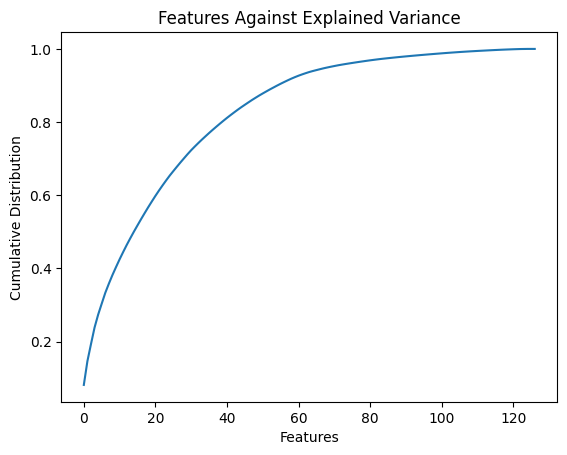

In [18]:
x = np.arange(0,len(cumsum),1)

plt.plot(x,cumsum)
plt.xlabel("Features")
plt.ylabel("Cumulative Distribution")
plt.title("Features Against Explained Variance")
plt.show()

With that it seems that about 60 features is enough to get about 90% of the data, I will still check with code.

In [19]:
for prob in range(85,101,1):
    print(f" features: {(np.argmax(cumsum >= prob/100)+1)} cover {prob}% of dataset")




 features: 47 cover 85% of dataset
 features: 48 cover 86% of dataset
 features: 50 cover 87% of dataset
 features: 52 cover 88% of dataset
 features: 54 cover 89% of dataset
 features: 56 cover 90% of dataset
 features: 58 cover 91% of dataset
 features: 60 cover 92% of dataset
 features: 62 cover 93% of dataset
 features: 66 cover 94% of dataset
 features: 70 cover 95% of dataset
 features: 75 cover 96% of dataset
 features: 82 cover 97% of dataset
 features: 92 cover 98% of dataset
 features: 104 cover 99% of dataset
 features: 125 cover 100% of dataset


As you can see around 60 features cover 92% of the dataset. This much easier to manage than the 125 features we have. That means the 'last' 65  PCA features compose only 8% of the variance of the dataset. It shows that we can greatly reduce the dimensionality of the dataset.  

However one must understandd each pca feature is formed by contributions of our actual features. We can sum the 'contributions' each feature has had on the 'transformed' PCA feature, by looping through the '.components_' attribute of our PCA object. 

This is shown on the code below.

In [40]:
# This is the number of generated pca components, since I left the default option it will match my feature size
print(len(pca_dating.components_))


#Here is the size of the array of the first pca component, it will be made of all the features I have put inside.
print(len(pca_dating.components_[0]))

127
127


Having this in mind, I will loop through the first 60 PCA components, and find the features that have contributed the most to all of them, by taking the absolute value of their contributions. 

To do this I will make a dictionary with feature name as a key, and total contribution as a value. 

In [41]:
#pca_dating.components_[0]

#getting the feature names in
feature_names = pca_dating.feature_names_in_

#Making a dictionary of every feature, and setting its pair to 0
feature_contributions = {feature: 0 for feature in feature_names}

#we are going to see which feature contributes the most to the top 120 features.
for  idx, pca_component in enumerate(pca_dating.components_):
    
    #As shown by the CumSum analysis, I only want the first 60
    if (idx <60):
    #adding the absolute value to see
        for index, feature in enumerate((feature_contributions.keys())):
            feature_contributions[feature] += abs(pca_component[index])
    else:
        break

    

With the dictionary made, I need to sort them by values, to see which feature is the most impactful.

In [42]:
#we want to see the features sorted by who contributes the most, we have to sort the dict for that
sorted_feature_contributions = dict(sorted(feature_contributions.items(), key=lambda x:x[1], reverse=True))

sorted_feature_contributions

{'age': 5.604383217852246,
 'd_ambtition_important': 5.225972593096411,
 'age_o': 5.101081351024366,
 'd_pref_o_ambitious': 4.868476045124459,
 'd_shared_interests_important': 4.826075077087382,
 'd_pref_o_shared_interests': 4.758252974042752,
 'samerace': 4.753078085190766,
 'd_ambition_partner': 4.7192928333377235,
 'd_shared_interests_partner': 4.683118525910068,
 'd_sincere_important': 4.634088056131706,
 'd_sincere_partner': 4.628155763813128,
 'd_sincere': 4.609138329931975,
 'funny': 4.606910966819816,
 'd_guess_prob_liked': 4.587981679086107,
 'd_ambitous_o': 4.576677687326692,
 'dining': 4.533808736503161,
 'd_shopping': 4.52108292541715,
 'd_reading': 4.519963863105722,
 'd_dining': 4.506026253683043,
 'd_sports': 4.501527820333434,
 'd_attractive': 4.4940419835640535,
 'd_music': 4.490199562368982,
 'd_intelligence': 4.488033186021991,
 'd_attractive_partner': 4.486669047830632,
 'd_hiking': 4.462274831175135,
 'd_funny': 4.454941209043443,
 'd_exercise': 4.454348303939569,


Here we can see the features that contribute the most (negatively or positively) to the PCA features. In this case we have done for all the features, lets see the top 30.

In [43]:
impactful_features = list(sorted_feature_contributions.keys())[:30]

['age',
 'd_ambtition_important',
 'age_o',
 'd_pref_o_ambitious',
 'd_shared_interests_important',
 'd_pref_o_shared_interests',
 'samerace',
 'd_ambition_partner',
 'd_shared_interests_partner',
 'd_sincere_important',
 'd_sincere_partner',
 'd_sincere',
 'funny',
 'd_guess_prob_liked',
 'd_ambitous_o',
 'dining',
 'd_shopping',
 'd_reading',
 'd_dining',
 'd_sports',
 'd_attractive',
 'd_music',
 'd_intelligence',
 'd_attractive_partner',
 'd_hiking',
 'd_funny',
 'd_exercise',
 'd_shared_interests_o',
 'intelligence',
 'sincere']

It is interesting that a 'generated' feature such as the 'd_ambition_important' is so impactful on our PCA analysis. A problem we have is that a lot of these 'generated' features are at the top, and are heavily correlated to one another. Here on the top 30 we can see 4 correlated features, 'd_sincere_important', 'd_sincere_partner', 'd_sincere', and 'sincere'. Which is not ideal. 

Since they are all calculated as 'differences' from other features, they are essentially noise . Hence, I am going to extract, what I call 'core' features, (all of those that don't start with 'd_'). 

In [47]:
# Here I will print 'core' features and show their values

# I will also make a dictionary of these features.
core_feature_contributions = {}

for feature in sorted_feature_contributions:
    if(feature[0:2] != 'd_'):
        core_feature_contributions[feature] = sorted_feature_contributions[feature]
        print(f"{feature} : {sorted_feature_contributions[feature]} ")

age : 5.604383217852246 
age_o : 5.101081351024366 
samerace : 4.753078085190766 
funny : 4.606910966819816 
dining : 4.533808736503161 
intelligence : 4.411971323574167 
sincere : 4.4084791165140675 
guess_prob_liked : 4.388439461481066 
attractive : 4.369419055953053 
expected_happy_with_sd_people : 4.361294628201124 
ambition : 4.3312514946956755 
movies : 4.328909404636884 
exercise : 4.322361368073632 
sincere_partner : 4.264370368669874 
attractive_partner : 4.256036274461788 
shopping : 4.25234989090647 
importance_same_race : 4.238957773006208 
ambitous_o : 4.238587851682582 
tv : 4.231596617345202 
sports : 4.2275668386996665 
met : 4.221306848657902 
reading : 4.213734618598438 
sinsere_o : 4.195242582653135 
importance_same_religion : 4.19286535994322 
ambition_partner : 4.175192357733737 
clubbing : 4.171738788279211 
shared_interests_partner : 4.166290898342382 
shared_interests_important : 4.156970706801166 
music : 4.155582834355904 
interests_correlate : 4.1490436100797

In [48]:
#calculating the number of features.
len(core_feature_contributions.keys())

71

What is interesting to see is that most of the one-hot-encoded values, which provide sparse data, are at the bottom in feature impact.

 We can see here by printing the last 15 features.

However 'samerace' which is also a boolean is seen on the top.

In [50]:
list(core_feature_contributions.keys())[-15:]

['pref_o_attractive',
 'museums',
 'like',
 'race_o_European/Caucasian-American',
 'race_European/Caucasian-American',
 'gender_male',
 'race_Asian/Pacific Islander/Asian-American',
 'race_o_Asian/Pacific Islander/Asian-American',
 'race_Latino/Hispanic American',
 'match_1',
 'race_o_Latino/Hispanic American',
 'race_Black/African American',
 'race_Other',
 'race_o_Black/African American',
 'race_o_Other']


I want to visualize the impact of the 'generated features' in comparison to the core features. To do this, I will use t-SNE to plot generated features and core features and see if the visualization looks different.

### Using t-SNE to inspect the impact of generated features


The main goal of using t-SNE here is to visualize my data. I want to see mainly if the shape of the generated features is very different from the core features. 

In [52]:
from sklearn.manifold import TSNE

# getting the columns for core features 
core_features_cols = list(core_feature_contributions.keys())

#getting the columns for generated features
generated_features_cols = list(set(feature_contributions.keys()) - set(core_feature_contributions) )

#we can get a dataframe for each of these

core_features_df = main_df[core_features_cols]

generated_features_df = main_df[generated_features_cols]


core_features_tsne = TSNE(n_components=2, learning_rate='auto').fit_transform(core_features_df)
generated_features_tsne = TSNE(n_components=2, learning_rate='auto').fit_transform(generated_features_df)



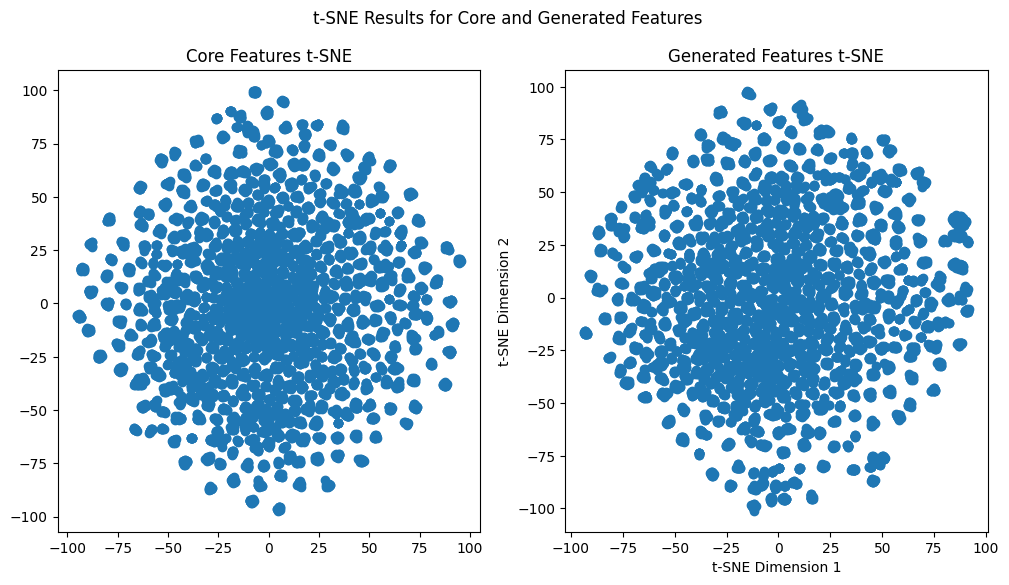

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the t-SNE results for the core features
axs[0].scatter(core_features_tsne[:, 0], core_features_tsne[:, 1])
axs[0].set_title('Core Features t-SNE')

# Plotting the t-SNE results for the generated features
axs[1].scatter(generated_features_tsne[:, 0], generated_features_tsne[:, 1])
axs[1].set_title('Generated Features t-SNE')


fig.suptitle('t-SNE Results for Core and Generated Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Show the plot
plt.show()

We can see here that both shapes are very similar, a sort of diamond shape. We can also see that the 'core' Features t-SNE is more densely packed in the middle which is very interesting. 

Since the shapes are very similar I will take the liberty of completely dropping all the generated features, and I will as well drop the bottom 15 features from my core features that are not race, gender or match. This is because I want to cluster other features. Race,gender and if they matched I will use later on my data vizualization as 'markers' to identify my clusters. 

This will be more clear further down

T-SNE is known to be hard to interpret so I will plot an ISO-map of my reduced dataset vs my original dataset. To determine if I can further reduce my features before implementing clustering. 

In [62]:
#I have counted and I know that the race, gender, and match encoded are the bottom 12 rows, hence I need to drop 15 more (27) to achieve my result.
core_features_to_remove = list(core_feature_contributions.keys())[-27:]

reduced_core_features_col = list(set(core_features_cols) - set(core_features_to_remove))


reduced_core_features_df = main_df[reduced_core_features_col]

In [ ]:
from sklearn.manifold import Isomap

iso_core_full = Isomap(n_components=2).fit_transform(core_features_df)

iso_core_reduced = Isomap(n_components=2).fit_transform(reduced_core_features_df)





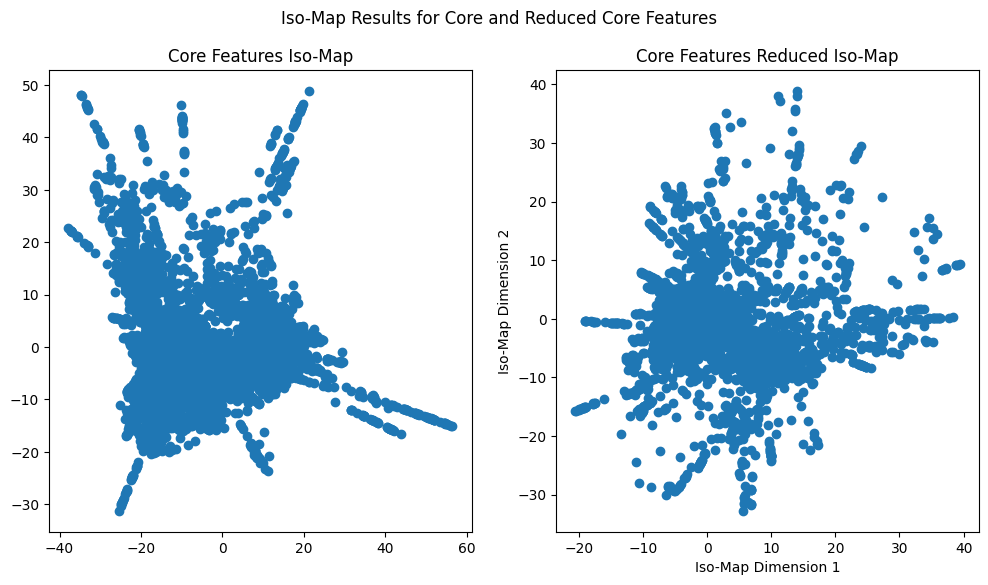

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plotting the t-SNE results for the core features
axs[0].scatter(iso_core_full[:, 0], iso_core_full[:, 1])
axs[0].set_title('Core Features Iso-Map')

# Plotting the t-SNE results for the generated features
axs[1].scatter(iso_core_reduced[:, 0], iso_core_reduced[:, 1])
axs[1].set_title('Core Features Reduced Iso-Map')


fig.suptitle('Iso-Map Results for Core and Reduced Core Features')
plt.xlabel('Iso-Map Dimension 1')
plt.ylabel('Iso-Map Dimension 2')

# Show the plot
plt.show()
plt.show()

It is very interesting to see that removing these features 'opened up' the top right area, and reduced the density, which is very useful for clustering. Additionally, we can see that the axes changed, and we have less outliers. 

This encourages the use of the reduced_core features for our clustering.

In [67]:
len(reduced_core_features_col)

44

Which we can see here are in total 44, so we have reduced our features to approximately 1/3 of our original dataset. 


## Step 3: Categorizing Features Before Clustering

After greatly reducing the number of features of our dataset to 44, we can manually verify the type of features that are left.

In [71]:
reduced_core_features_col

['sinsere_o',
 'music',
 'ambition_partner',
 'sincere_important',
 'ambition',
 'guess_prob_liked',
 'importance_same_race',
 'yoga',
 'attractive_partner',
 'age',
 'reading',
 'intelligence_partner',
 'shopping',
 'interests_correlate',
 'exercise',
 'shared_interests_important',
 'funny',
 'met',
 'importance_same_religion',
 'hiking',
 'clubbing',
 'expected_num_matches',
 'wave',
 'expected_happy_with_sd_people',
 'attractive',
 'gaming',
 'ambitous_o',
 'tv',
 'theater',
 'funny_important',
 'shared_interests_o',
 'intelligence',
 'tvsports',
 'age_o',
 'samerace',
 'shared_interests_partner',
 'ambtition_important',
 'movies',
 'sincere',
 'sincere_partner',
 'dining',
 'sports',
 'attractive_o',
 'intellicence_important']

Here we can see that the features are actually in different categories, of the type: 'Interests', 'Physicality', 'Personality', 'Preferences', 'Event Outlook'. 

It will be interesting to separate these features in categories, to see later analyze them relevant to our clusters derived from k-means. 

I will first manually extract general interests.

In [75]:
interest_cols = ['music', 'yoga', 'reading', 'shopping', 'exercise', 'hiking', 'clubbing', 'gaming', 'tv', 'theater', 'tvsports', 'movies', 'dining', 'sports']

With the interests out of the way, I will extract the features that correspond to 'Physicality'

In [77]:
physical_cols = ['importance_same_race', 'attractive_partner', 'age', 'attractive', 'age_o', 'samerace', 'attractive_o']

I will now extract features that correspond to 'Personality'

In [79]:
personality_cols = ['sinsere_o', 'ambition_partner', 'ambition', 'intelligence_partner', 'funny', 'ambitous_o', 'intelligence', 'sincere_partner', 'sincere']

Extracting features that correspond to 'Preferences'.

In [83]:
preference_cols = ['shared_interests_partner', 'interests_correlate', 'funny_important', 'importance_same_religion', 'shared_interests_o', 'intellicence_important', 'ambtition_important','shared_interests_important',
 'sincere_important', ]

Finally Extracting 'Event Outlook' Features

In [85]:
outlook_cols = ['expected_num_matches', 'guess_prob_liked', 'expected_happy_with_sd_people']

With this extraction complete, we can clusterize using k means and see how the clusters are impacted on these 5 categories. 

Additionally there are 2 features I don't know what they are, so I have excluded them, they are shown below.

In [86]:
list(set(reduced_core_features_col) - set(interest_cols) - set(physical_cols) - set(personality_cols)-set(preference_cols) - set(outlook_cols))

['met', 'wave']

Now we are ready to cluster them.

## Step 4: Clustering with K-means the selected features

With our feature categories established, we will apply the k-means algorithm to extract our data, as it is one of the most standard unsupervised methods technique. 

We will also extract the optimal number of clusters using the elbow method, and will then plot the various graphs using the clusters, the categories, gender, race and match. 

Before clustering I must append extract a dataframe with the reduced core features, as well as the OHE columns (race, gender, match)

In [119]:
ohe_cols = ['gender_male', 'race_Asian/Pacific Islander/Asian-American',
       'race_Black/African American', 'race_European/Caucasian-American',
       'race_Latino/Hispanic American', 'race_Other',
       'race_o_Asian/Pacific Islander/Asian-American',
       'race_o_Black/African American',
       'race_o_European/Caucasian-American',
       'race_o_Latino/Hispanic American', 'race_o_Other', 'match_1']


clustering_cols = ohe_cols + interest_cols + physical_cols +  personality_cols + preference_cols + outlook_cols

#Making a dataframe with my selected columns
df_cluster = main_df[clustering_cols].copy()

Running the k-means algorithm finding with elbow method.

In [120]:
from sklearn.cluster import KMeans

#I will automatically apply the elbow method on the kmeans algorithm
# Additionally sklearn has by default k++ initialization so I should be ok

inertias = []
for k in range (3,50):
    kmns = KMeans(n_clusters=k, n_init='auto', random_state=42)
    kmns.fit(df_cluster)
    inertias.append(kmns.inertia_)


Now to plot to find the 'elbow'

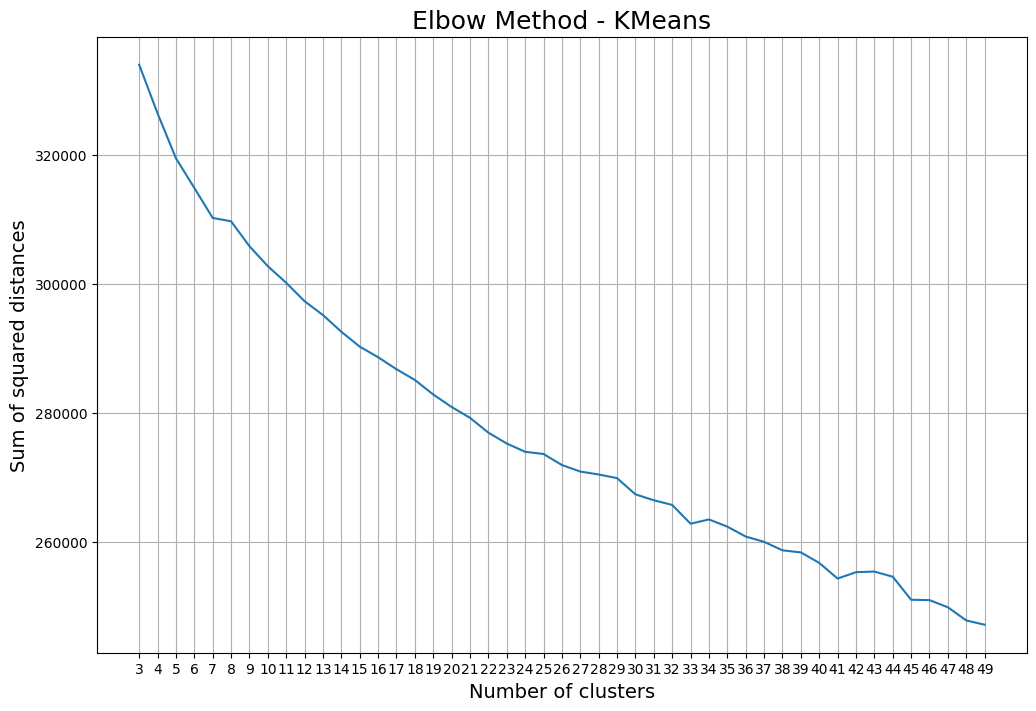

In [121]:
import seaborn as sns

plt.figure(figsize=(12,8))
g = sns.lineplot(y=inertias, x=np.arange(3,50))
g.set_ylabel('Sum of squared distances', fontsize=14)
g.set_xlabel('Number of clusters', fontsize=14)
g.set_xticks(range(3,50))
g.set_title('Elbow Method - KMeans', fontsize=18)
plt.grid('on')
plt.show()

As you can see it's impossible to find the elbow, I will resort to the silhouette score as an alternative.

In [110]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2,30):
    kmns = KMeans(n_clusters=k,
                  n_init='auto',
                  random_state=42)
    kmns.fit(df_cluster)
    sil_score = silhouette_score(df_cluster, kmns.labels_)
    sil_scores.append(sil_score)

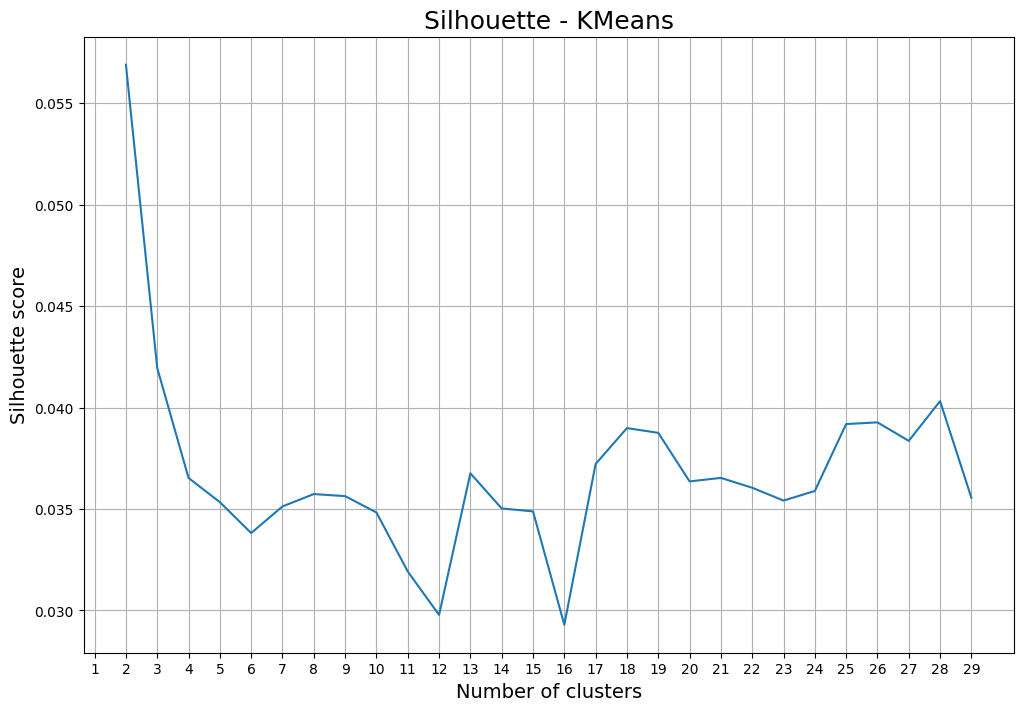

In [111]:

plt.figure(figsize=(12,8))
g = sns.lineplot(y=sil_scores, x=np.arange(2,30))
g.set_ylabel('Silhouette score', fontsize=14)
g.set_xlabel('Number of clusters', fontsize=14)
g.set_xticks(range(1,30))
g.set_title('Silhouette - KMeans', fontsize=18)
plt.grid('on')
plt.show()

Here we can see that with the silhoutte score, it's better to determine a 'good' number of clusters. In reality all are bad, if we see the low silhoutte scores. This is probably due to the high-dimensionality of data. 

Nevertheless we can see that 13, 18 and 28 are good values for the clusters.

This is the entire selected features dataset, however I am wondering if we can cluster people on something more abstract, such as preferences, or a combination of them.

With the low values of these silhoutte scores, I don't expect to extract meaningful insights. 

Hence I will cluster independently one one of my chosen categories 'Preferences'. 

**However I would like to note this analysis could be done with any of the other categories**

## Step 5: Clustering on one Category (Preferences)

### Clustering on 'PREFERENCES'

As a reminder the preference columns are these ones:

In [112]:
preference_cols

['shared_interests_partner',
 'interests_correlate',
 'funny_important',
 'importance_same_religion',
 'shared_interests_o',
 'intellicence_important',
 'ambtition_important',
 'shared_interests_important',
 'sincere_important']

I will repeat the code above, but make a dataframe out of preference only

In [114]:
sil_scores = []
for k in range(2,30):
    kmns = KMeans(n_clusters=k,
                  n_init='auto',
                  random_state=42)
    kmns.fit(main_df[preference_cols].copy())
    sil_score = silhouette_score(main_df[preference_cols].copy(), kmns.labels_)
    sil_scores.append(sil_score)

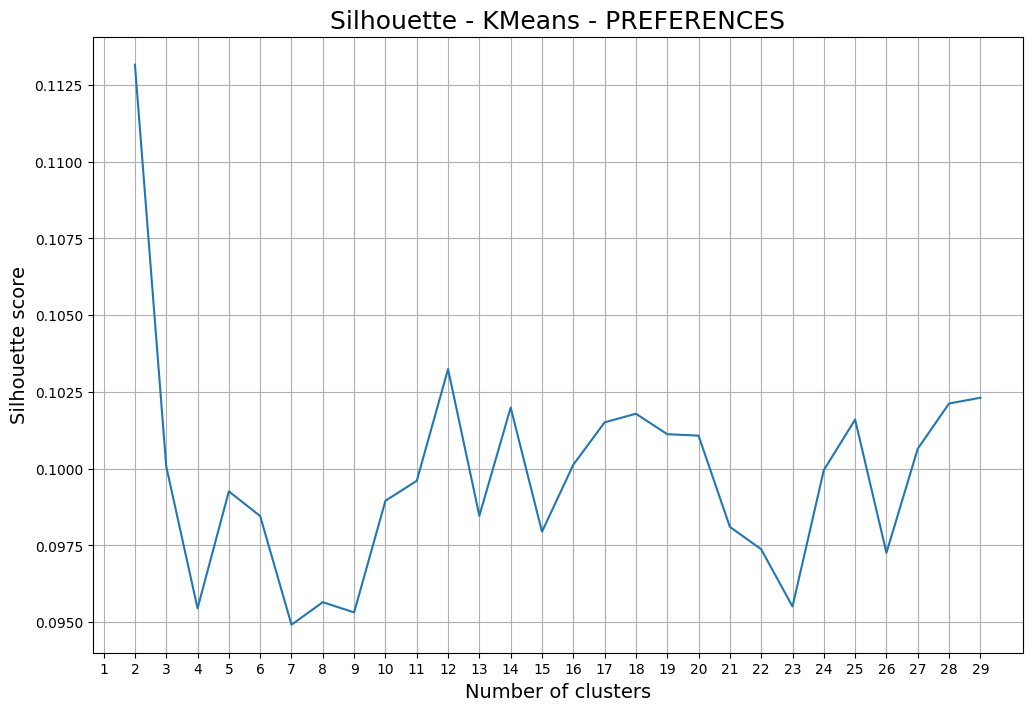

In [115]:

plt.figure(figsize=(12,8))
g = sns.lineplot(y=sil_scores, x=np.arange(2,30))
g.set_ylabel('Silhouette score', fontsize=14)
g.set_xlabel('Number of clusters', fontsize=14)
g.set_xticks(range(1,30))
g.set_title('Silhouette - KMeans - PREFERENCES', fontsize=18)
plt.grid('on')
plt.show()

Curious that there seems to be a huge variety in preferences (who would've thought!) 12 looks like the winner here, considering there are only 9 features, it is far from ideal. 

However we will still pairplot them to attempt to gain insights. I will cluster in 12 clusters, and see if I can find any interesting data. 

In [130]:
kmns_preference = KMeans(n_clusters=12,
                  n_init='auto',
                  random_state=42)
kmns_preference.fit(main_df[preference_cols].copy())


preference_df = main_df[preference_cols].copy()


preference_df.loc[:,'Labels'] = kmns_preference.labels_

ohe_original_cols = cat_cols


df_cat = df[ohe_original_cols].copy()

preference_df_graph = preference_df.join(df_cat.copy(), how='outer')

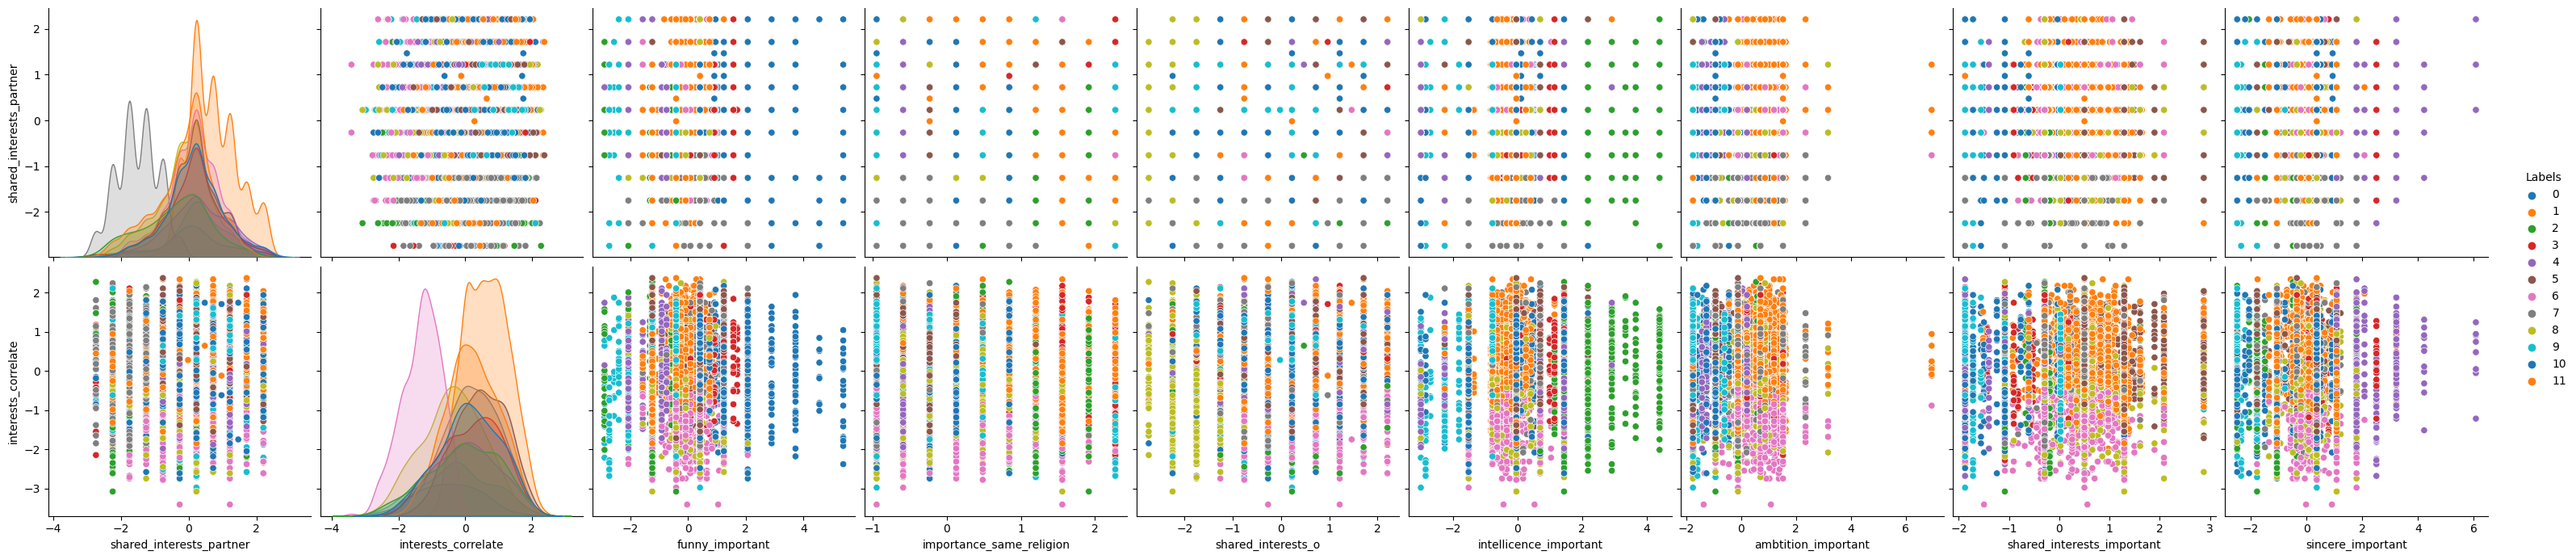

In [134]:
preferences = sns.pairplot(preference_df_graph.drop(list(df_cat.columns), axis=1),
                 hue='Labels',
                 palette=sns.color_palette("tab10",len(np.unique(kmns_preference.labels_))),
                 y_vars=['shared_interests_partner', 'interests_correlate'],
                 height=3.5)

plt.grid(False)
plt.show()

I know this is a hard to graph to see, but we can see a bit of our data. If we consider our y axis variables, shared_interests_partner, and interests_correlate, we can see how some clusters are defined. 
- We can see that dark blue clearly prefer funny people. 
- That orange types are religous.
- Pinks want the polar opposite from who they are. 

In particular I want to focus on one group.

- ***Light blue*** doesn't care at all about religion, if their partner is funny, if they their partners are ambitious, or intellligent, or sincere. 

Seem they like they would go for anything. 
This could also mean their standards are lower due for them being in general seen as less attractive, or older.


Future investigation would be very interesting as an example from here, I could focus on light blue and investigate more about them, by appending these clustering labels to my other dataframes. 

For example I am almost sure light blue are probably a majority,  men, as they have almost no standards. I could check their gender to confirm my hypothesis. Then I could further investigate the race, and match rate of these groups. 

So let's figure out!

## Step 6: Profiling the 'Light Blue' Cluster

In [157]:
light_blues = preference_df_graph.loc[preference_df['Labels'] == 9]
light_blues = light_blues.iloc[:, :-1]

In [158]:
light_blues.columns

Index(['shared_interests_partner', 'interests_correlate', 'funny_important',
       'importance_same_religion', 'shared_interests_o',
       'intellicence_important', 'ambtition_important',
       'shared_interests_important', 'sincere_important', 'Labels', 'gender',
       'race', 'race_o', 'match'],
      dtype='object')

Checking the gender to see if my hypothesis is true.

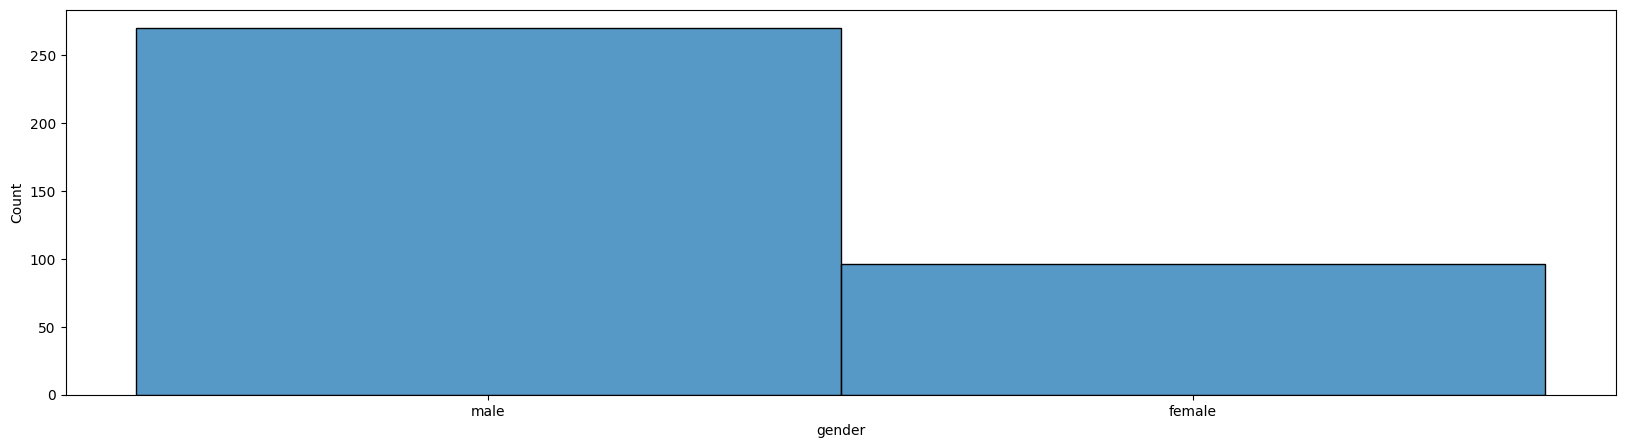

In [159]:
#Lets
plt.figure(figsize=(20,5))
ax = sns.histplot(data=light_blues, x='gender')

Surprisingly a large amount of number of females, yet as predicted there are still approximately 3x males then females on the group.

We can also check their races to see the distribution

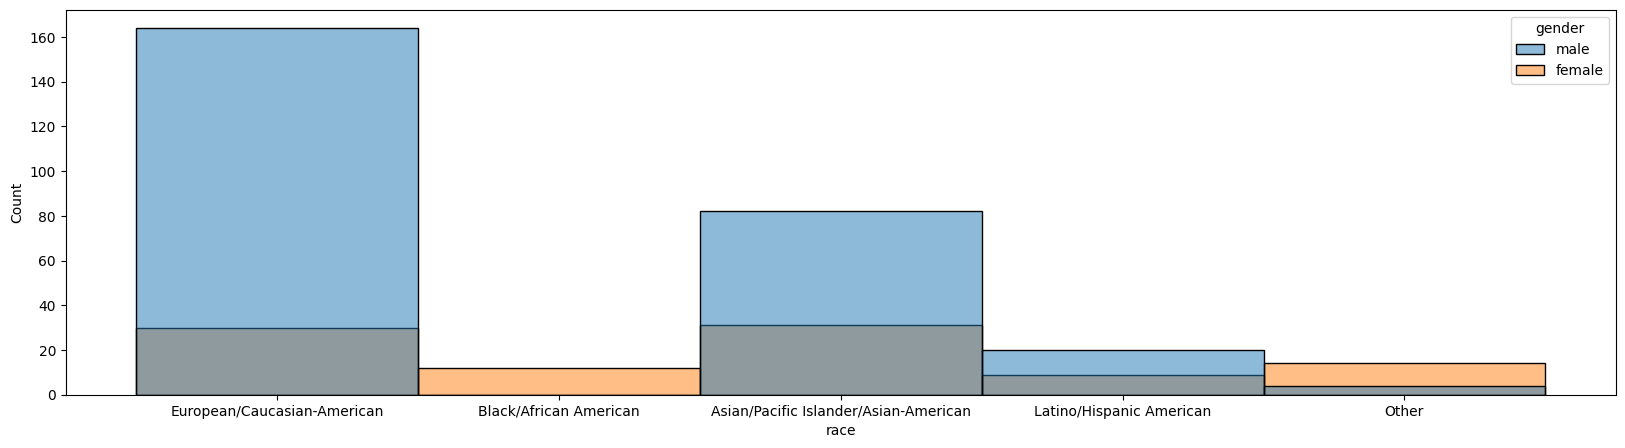

In [160]:
#Lets
plt.figure(figsize=(20,5))
ax = sns.histplot(data=light_blues, x='race', hue='gender')


plt.show()

Here we can see that no Black/African American men are found in this cluster, seems like they have their own specific cluster, yet there are a significant number of Black/African American females. As well as on the 'Other' category which I'm not sure what they are. Assuming this data is from the US it's no surprise there are a majority European-American males due to the distribution of data, but it is interesting the amount of 'Asian-Americans' compared to Latinos as they are a minority. To confirm this we can check with by doing a pandas count.

In [161]:
males =  df.loc[df['gender'] == "male"]


males['race'].value_counts()


European/Caucasian-American              2540
Asian/Pacific Islander/Asian-American     937
Other                                     277
Latino/Hispanic American                  261
Black/African American                    179
Name: race, dtype: int64

We can see I was wrong, and that in this event there are significantly more Asian-American's than latinos, and the data is shown accordingly.

Now I want to check if the light blues are more on the 'undesirable' side as shown by their standards.

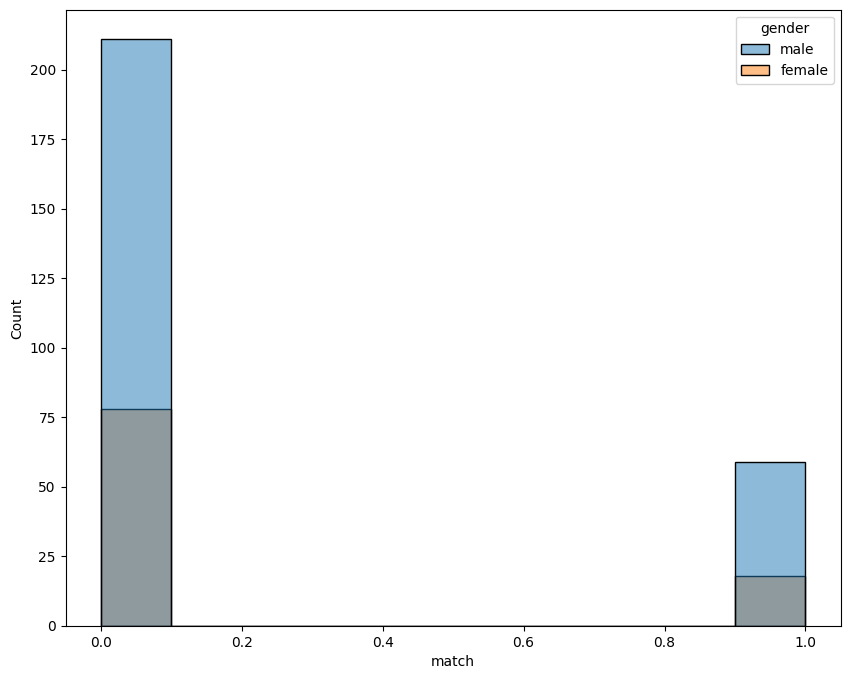

In [164]:
#Lets
plt.figure(figsize=(10,8))

ax = sns.histplot(data=light_blues, x='match', hue='gender')

plt.show()


Here we can see as predicted, the majority did not get any matches, despite their low standards. With a small minority getting lucky.

## Step 7: Conclusion

In essence I could continue my analysis on this group, I could find their age, their main interests etc etc. As well as investigate the other clusters.

I could continue my analysis by clustering depending on my other categories, for example interests, and see how the sporty types do, what preferences they have.

The list is endless, I hope I showed you with this we could profile these contestants exhaustively. 

My main takeway from this project was after reducing dimensions, analyzing your features and grouping them in different categories.  

Once you have them grouped, you can cluster on specific set of features, and draw insights on your 'customers' or whatever you are clustering by appending other features. 